In [1]:
import warnings
from anndata import ImplicitModificationWarning
warnings.filterwarnings("ignore", category=ImplicitModificationWarning)
warnings.filterwarnings("ignore")

In [2]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import numpy as np
import scanpy as sc
import vqtcr as vq

In [3]:
path_base = '/mnt/d/Dataset/vqTCR/10xGenomics/'
path_data = path_base + 'avidity_esm.h5ad'

In [4]:
vq.set_random_seed(2025)
adata = sc.read_h5ad(path_data)
adata = adata[adata.obs['binding_name'].isin(vq.HIGH_COUNT_ANTIGENS)]
adata

View of AnnData object with n_obs × n_vars = 61096 × 5000
    obs: 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir', 'barcode',

In [5]:
params = vq.get_pred_config(lr=1e-4, latent_dim=64, dropout=0.2)
params['epoch'] = 20
params['tcr']['dim_emb'] = 64 # 320 for only attention (esm2)
params

{'dim_latent': 64,
 'batch_size': 512,
 'lr': 0.0001,
 'dropout': 0.2,
 'epoch': 20,
 'early': 10,
 'dataset': '',
 'save_path': '',
 'direction': 'max',
 'weight_decay': 0.0001,
 'loss_weight': [1.0, 1.0, 1.0, 1.0],
 'gex': {'dim_latent': 64, 'act': 'elu', 'norm': True},
 'tcr': {'esm_type': 'facebook/esm2_t6_8M_UR50D',
  'kmer_kernels': [1, 3, 5, 7],
  'dim_latent': 64,
  'dim_emb': 64,
  'num_heads': 8,
  'forward_expansion': 4,
  'dropout': 0.2,
  'num_encoder': 2,
  'num_decoder': 2,
  'mask_rate': 0.15,
  'beta_only': False,
  'esm_tokens': True},
 'fus': {'dim_latent': 64, 'dropout': 0.2, 'film_reg': 1.0},
 'pty': {'dim_latent': 128,
  'num_subspace': 3,
  'codewords_per_space': 64,
  'eps': 1e-05,
  'init_scale': 1.0,
  'ema_decay': 0.99,
  'commitment_beta': 0.25,
  'use_cosine': True,
  'dead_code_interval': 1000,
  'dead_code_threshold': 0.0001,
  'dead_code_topk': 16,
  'diversity_weight': 0.001},
 'pred': {'dim_latent': 64, 'dropout': 0.2, 'n_labels': 8}}

Leave one donor out(LoDonor) TCR-pMHC binding prediction

pretrain on all donors

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


warmup codebook:   0%|          | 0/20 [00:00<?, ?it/s]

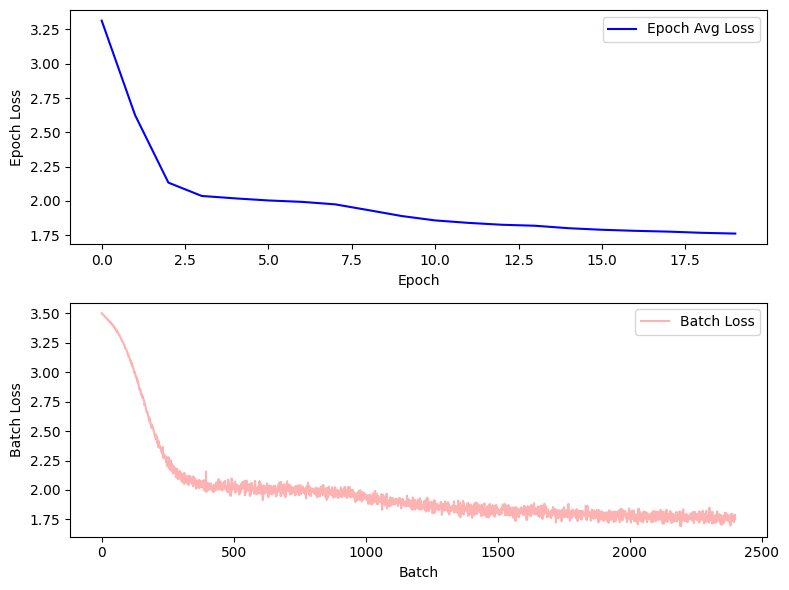

In [6]:
vqtcr = vq.vqTCR_Bench(params, adata, labels='binding_name', model='TCR')
vqtcr.pretrain(col_name='donor', 
               set_name=['donor_1', 'donor_2', 'donor_3', 'donor_4'],
               sample_mode='clonotype', 
               shuffle=False,
               labels=None,
               visual=True)

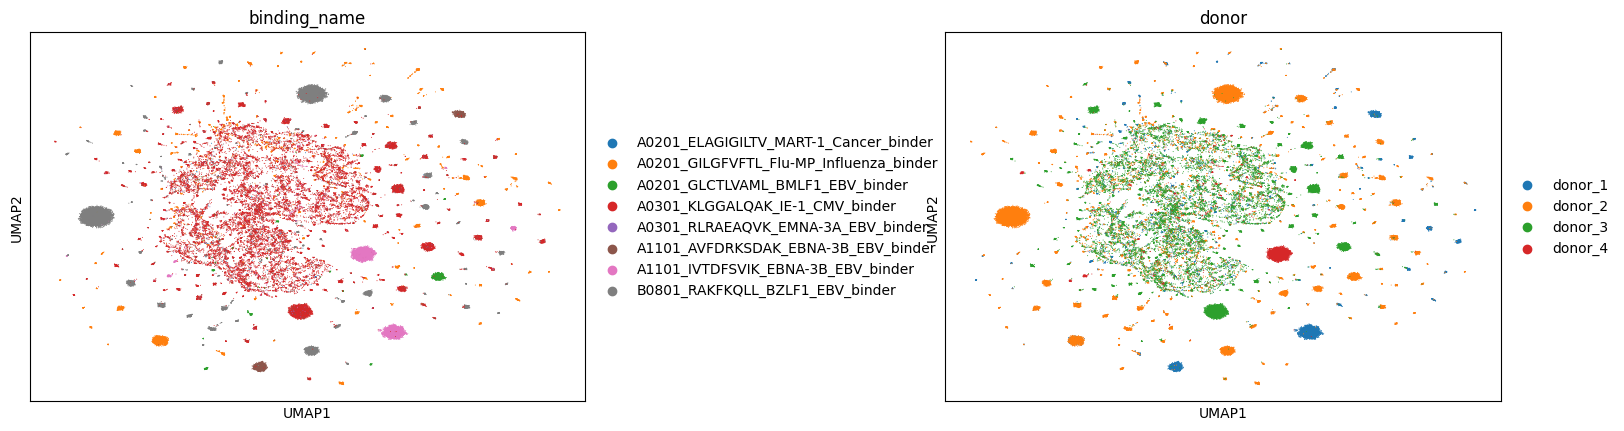

In [7]:
adata = vqtcr.get_latent(adata, col_name='donor', set_name=['donor_1', 'donor_2', 'donor_3', 'donor_4'])
# tcell latent space
sc.pp.neighbors(adata, use_rep='htcell')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['binding_name', 'donor'], wspace=0.5)

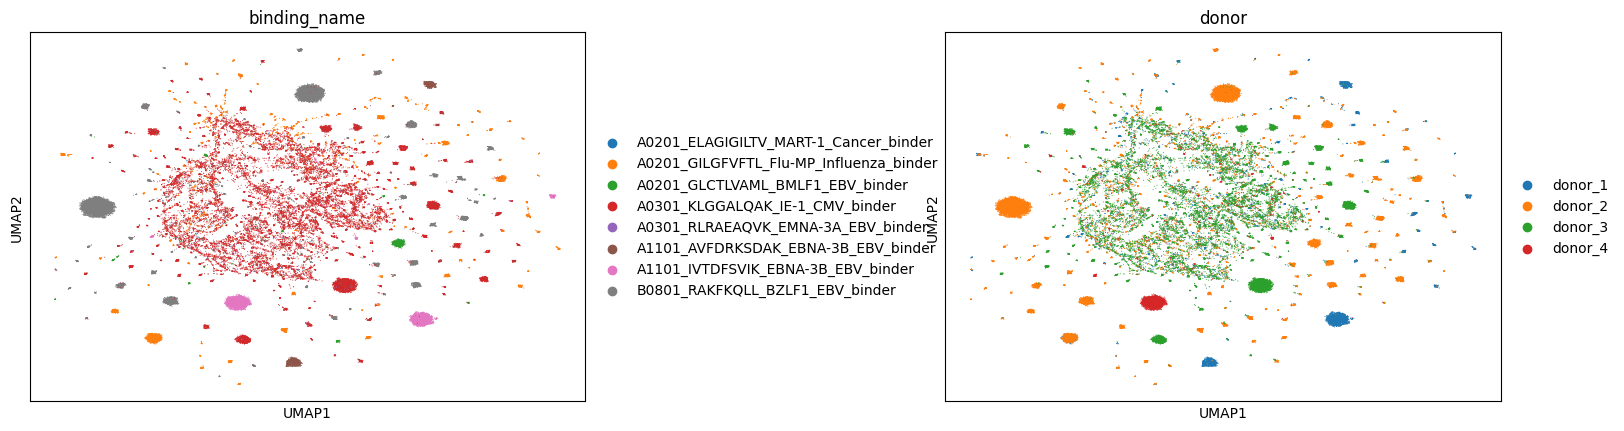

In [8]:
# tcr latent space
sc.pp.neighbors(adata, use_rep='htcr')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['binding_name', 'donor'], wspace=0.5)

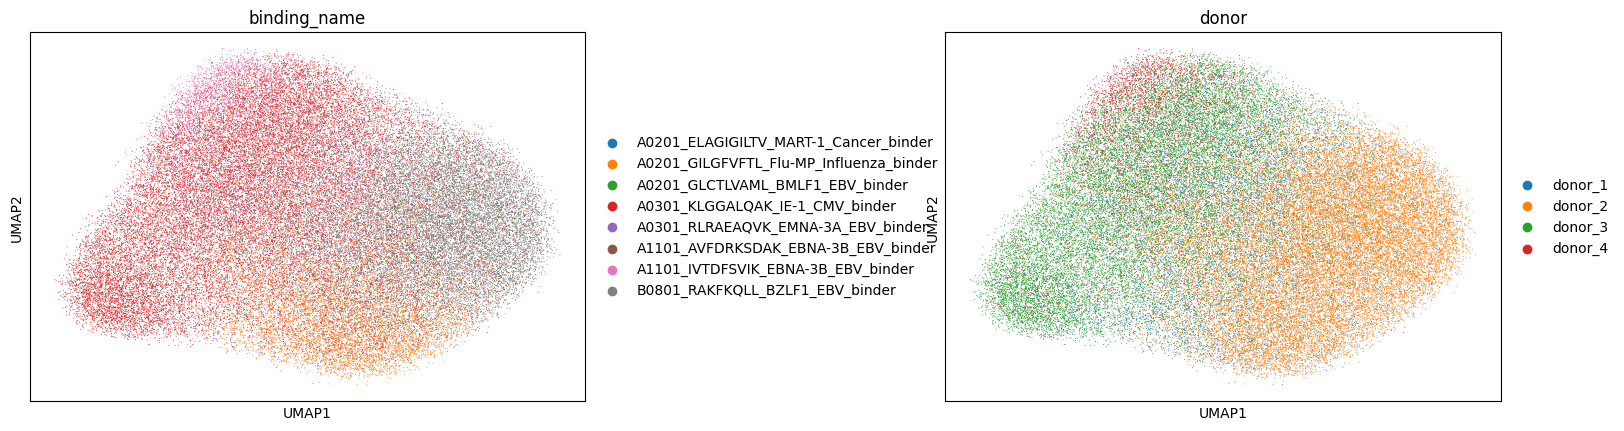

In [9]:
# gex latent space, not learned
sc.pp.neighbors(adata, use_rep='hgex')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['binding_name', 'donor'], wspace=0.5)

prediction training on remianing patients and test on leave-out patient

In [10]:
# test_score = vqtcr.compute_metrics(metrics='knn_prediction', eval_set='test')
record = {}
adata = vqtcr.get_latent(adata,col_name='donor', set_name=['donor_1', 'donor_2', 'donor_3', 'donor_4'])
adata_train = adata[adata.obs['set'].isin(['train', 'valid'])]
adata_valid = adata[adata.obs['set']=='test']

knn_scores = vq.get_knn_cls(adata_train.obsm['htcr'], adata_valid.obsm['htcr'],
                            adata_train.obs['binding_name'], 
                            adata_valid.obs['binding_name'])
record['knn_prediction'] = knn_scores['weighted avg']['f1-score']
record['knn_prediction']

0.463046188989096

In [11]:
adata = vq.split_adata(adata, split_col='clonotype', random_seed=2025)
record = {}
adata = vqtcr.get_latent(adata, col_name='donor', set_name=['donor_1', 'donor_2', 'donor_3', 'donor_4'])
adata_train = adata[adata.obs['set']=='train']
adata_valid = adata[adata.obs['set']=='test']

knn_scores = vq.get_knn_cls(adata_train.obsm['htcr'], adata_valid.obsm['htcr'],
                            adata_train.obs['binding_name'], 
                            adata_valid.obs['binding_name'])
record['knn_prediction'] = knn_scores['weighted avg']['f1-score']
record['knn_prediction']

0.8335302555522325

In [12]:
from sklearn.model_selection import LeaveOneGroupOut, LeavePGroupsOut
logo = LeaveOneGroupOut()
all_test_metrics = []
donor_ids = adata.obs.donor.to_numpy()
import numpy as np
for train_valid_idx, test_idx in logo.split(X=adata.X, groups=donor_ids):
    test_donor = donor_ids[test_idx][0]
    print(f"\n=== test on {test_donor} ===")
    adata.obs.loc[adata.obs.index[train_valid_idx], 'set']='train'
    adata.obs.loc[adata.obs.index[test_idx], 'set'] = 'test'
    record = {}
    adata = vqtcr.get_latent(adata, col_name='donor', set_name=['donor_1', 'donor_2', 'donor_3', 'donor_4'])
    adata_train = adata[adata.obs['set']=='train']
    adata_valid = adata[adata.obs['set']=='test']

    knn_scores = vq.get_knn_cls(adata_train.obsm['htcr'], adata_valid.obsm['htcr'],
                                adata_train.obs['binding_name'], 
                                adata_valid.obs['binding_name'])
    record['knn_prediction'] = knn_scores['weighted avg']['f1-score']
    print(record['knn_prediction'])


=== test on donor_1 ===
0.8254993876678365

=== test on donor_2 ===
0.43225972919183875

=== test on donor_3 ===
0.7224295226412756

=== test on donor_4 ===
0.07581878302849172


In [13]:
all_test_metrics = []
for train_valid_idx, test_idx in logo.split(X=adata.X, groups=donor_ids):
    test_donor = donor_ids[test_idx][0]
    print(f"\n=== test on {test_donor} ===")
    # split train-valid dataset
    adata_train_val = adata[train_valid_idx]
    train, val = vq.split_dataset(adata_train_val, split_ratio=0.25, 
                                  split_col='clonotype', random_seed=2025)
    adata.obs['set'] = None
    adata.obs.loc[train.obs.index, 'set'] = 'train'
    adata.obs.loc[val.obs.index, 'set'] = 'valid'
    adata.obs.loc[adata.obs.index[test_idx], 'set'] = 'test'
    trainloader = vq.get_dataloader(adata=adata, 
                                     batch_size=params['batch_size'],
                                     col_name='set',
                                     set_name=['train'],
                                     sample_mode='clonotype',
                                     shuffle=False, 
                                     labels='binding_name')
    validloader = vq.get_dataloader(adata=adata, 
                                     batch_size=params['batch_size'],
                                     col_name='set',
                                     set_name=['valid'],
                                     sample_mode=None,
                                     shuffle=False, 
                                     labels='binding_name')
    testloader = vq.get_dataloader(adata=adata, 
                                     batch_size=params['batch_size'],
                                     col_name='set',
                                     set_name=['test'],
                                     sample_mode=None,
                                     shuffle=False, 
                                     labels='binding_name')
    best_score = vqtcr.predict_train(trainloader, validloader)
    print(f'best score in validation: {best_score}')
    
    test_metrics = vqtcr.predict_test(testloader)
    all_test_metrics.append(test_metrics)
    
metric = 'weighted'
print("\n" + "="*60)
print("LOGO交叉验证最终结果:")
for i, metrics in enumerate(all_test_metrics):
        print(f"病人 {np.unique(donor_ids)[i]}: "
              f"f1: {metrics[f'f1_{metric}']:.3f}, "
              f"AUC-ROC: {metrics[f'auc_roc_{metric}']:.3f}, "
              f"AUC-PR: {metrics[f'auc_pr_{metric}']:.3f}")
    
# 计算平均性能
mean_f1 = np.nanmean([m[f'f1_{metric}'] for m in all_test_metrics])
mean_auc_roc = np.nanmean([m[f'auc_roc_{metric}'] for m in all_test_metrics])
mean_auc_pr = np.nanmean([m[f'auc_pr_{metric}'] for m in all_test_metrics])

print(f"\n平均性能: "
        f"fa: {mean_f1:.3f} ± {np.nanstd([m[f'f1_{metric}'] for m in all_test_metrics]):.3f}, "
        f"AUC-ROC: {mean_auc_roc:.3f} ± {np.nanstd([m[f'auc_roc_{metric}'] for m in all_test_metrics]):.3f}, "
        f"AUC-PR: {mean_auc_pr:.3f} ± {np.nanstd([m[f'auc_pr_{metric}'] for m in all_test_metrics]):.3f}")


=== test on donor_1 ===


Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.546
Val F1: 0.214, Val AUC-ROC: 0.762, Val AUC-PR: 0.256
Epoch 2/20:
  Train Loss: 1.217
Val F1: 0.211, Val AUC-ROC: 0.826, Val AUC-PR: 0.304
Epoch 3/20:
  Train Loss: 0.991
Val F1: 0.211, Val AUC-ROC: 0.847, Val AUC-PR: 0.322
Epoch 4/20:
  Train Loss: 0.798
Val F1: 0.225, Val AUC-ROC: 0.882, Val AUC-PR: 0.344
Epoch 5/20:
  Train Loss: 0.893
Val F1: 0.236, Val AUC-ROC: 0.891, Val AUC-PR: 0.355
Epoch 6/20:
  Train Loss: 0.765
Val F1: 0.237, Val AUC-ROC: 0.898, Val AUC-PR: 0.362
Epoch 7/20:
  Train Loss: 0.689
Val F1: 0.287, Val AUC-ROC: 0.904, Val AUC-PR: 0.364
Epoch 8/20:
  Train Loss: 0.656
Val F1: 0.291, Val AUC-ROC: 0.906, Val AUC-PR: 0.362
Epoch 9/20:
  Train Loss: 0.806
Val F1: 0.397, Val AUC-ROC: 0.910, Val AUC-PR: 0.366
Epoch 10/20:
  Train Loss: 0.794
Val F1: 0.376, Val AUC-ROC: 0.907, Val AUC-PR: 0.364
Epoch 11/20:
  Train Loss: 0.824
Val F1: 0.397, Val AUC-ROC: 0.911, Val AUC-PR: 0.369
Epoch 12/20:
  Train Loss: 0.761
Val F1: 0.421, Val AUC-ROC: 0.

Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.678
Val F1: 0.324, Val AUC-ROC: 0.509, Val AUC-PR: 0.198
Epoch 2/20:
  Train Loss: 1.351
Val F1: 0.330, Val AUC-ROC: 0.539, Val AUC-PR: 0.259
Epoch 3/20:
  Train Loss: 1.158
Val F1: 0.330, Val AUC-ROC: 0.592, Val AUC-PR: 0.263
Epoch 4/20:
  Train Loss: 0.976
Val F1: 0.330, Val AUC-ROC: 0.621, Val AUC-PR: 0.288
Epoch 5/20:
  Train Loss: 0.941
Val F1: 0.330, Val AUC-ROC: 0.581, Val AUC-PR: 0.264
Epoch 6/20:
  Train Loss: 0.783
Val F1: 0.330, Val AUC-ROC: 0.579, Val AUC-PR: 0.265
Epoch 7/20:
  Train Loss: 0.821
Val F1: 0.330, Val AUC-ROC: 0.595, Val AUC-PR: 0.282
Epoch 8/20:
  Train Loss: 0.760
Val F1: 0.330, Val AUC-ROC: 0.713, Val AUC-PR: 0.319
Epoch 9/20:
  Train Loss: 0.745
Val F1: 0.330, Val AUC-ROC: 0.695, Val AUC-PR: 0.325
Epoch 10/20:
  Train Loss: 0.673
Val F1: 0.330, Val AUC-ROC: 0.691, Val AUC-PR: 0.302
Epoch 11/20:
  Train Loss: 0.689
Val F1: 0.330, Val AUC-ROC: 0.725, Val AUC-PR: 0.335
Epoch 12/20:
  Train Loss: 0.633
Val F1: 0.330, Val AUC-ROC: 0.

Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.764
Val F1: 0.198, Val AUC-ROC: 0.693, Val AUC-PR: 0.233
Epoch 2/20:
  Train Loss: 1.650
Val F1: 0.135, Val AUC-ROC: 0.752, Val AUC-PR: 0.282
Epoch 3/20:
  Train Loss: 1.478
Val F1: 0.157, Val AUC-ROC: 0.793, Val AUC-PR: 0.311
Epoch 4/20:
  Train Loss: 1.351
Val F1: 0.161, Val AUC-ROC: 0.843, Val AUC-PR: 0.348
Epoch 5/20:
  Train Loss: 1.387
Val F1: 0.175, Val AUC-ROC: 0.863, Val AUC-PR: 0.359
Epoch 6/20:
  Train Loss: 1.364
Val F1: 0.276, Val AUC-ROC: 0.850, Val AUC-PR: 0.377
Epoch 7/20:
  Train Loss: 1.252
Val F1: 0.277, Val AUC-ROC: 0.850, Val AUC-PR: 0.380
Epoch 8/20:
  Train Loss: 1.260
Val F1: 0.162, Val AUC-ROC: 0.859, Val AUC-PR: 0.380
Epoch 9/20:
  Train Loss: 1.230
Val F1: 0.266, Val AUC-ROC: 0.867, Val AUC-PR: 0.377
Epoch 10/20:
  Train Loss: 1.203
Val F1: 0.267, Val AUC-ROC: 0.887, Val AUC-PR: 0.407
Epoch 11/20:
  Train Loss: 1.189
Val F1: 0.268, Val AUC-ROC: 0.880, Val AUC-PR: 0.398
Epoch 12/20:
  Train Loss: 1.052
Val F1: 0.268, Val AUC-ROC: 0.

Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.518
Val F1: 0.320, Val AUC-ROC: 0.750, Val AUC-PR: 0.228
Epoch 2/20:
  Train Loss: 1.242
Val F1: 0.235, Val AUC-ROC: 0.755, Val AUC-PR: 0.254
Epoch 3/20:
  Train Loss: 0.718
Val F1: 0.235, Val AUC-ROC: 0.777, Val AUC-PR: 0.279
Epoch 4/20:
  Train Loss: 0.643
Val F1: 0.236, Val AUC-ROC: 0.804, Val AUC-PR: 0.299
Epoch 5/20:
  Train Loss: 0.293
Val F1: 0.270, Val AUC-ROC: 0.822, Val AUC-PR: 0.318
Epoch 6/20:
  Train Loss: 0.575
Val F1: 0.295, Val AUC-ROC: 0.797, Val AUC-PR: 0.309
Epoch 7/20:
  Train Loss: 0.695
Val F1: 0.320, Val AUC-ROC: 0.813, Val AUC-PR: 0.315
Epoch 8/20:
  Train Loss: 0.472
Val F1: 0.336, Val AUC-ROC: 0.834, Val AUC-PR: 0.328
Epoch 9/20:
  Train Loss: 3.189
Val F1: 0.369, Val AUC-ROC: 0.819, Val AUC-PR: 0.328
Epoch 10/20:
  Train Loss: 1.090
Val F1: 0.357, Val AUC-ROC: 0.834, Val AUC-PR: 0.327
Epoch 11/20:
  Train Loss: 1.021
Val F1: 0.407, Val AUC-ROC: 0.831, Val AUC-PR: 0.327
Epoch 12/20:
  Train Loss: 0.196
Val F1: 0.408, Val AUC-ROC: 0.

In [14]:
all_test_metrics = []
for i in range(5):
    adata = vq.split_adata(adata, split_col='clonotype', random_seed=i)
    trainloader = vq.get_dataloader(adata=adata, 
                                     batch_size=params['batch_size'],
                                     col_name='set',
                                     set_name=['train'],
                                     sample_mode='clonotype',
                                     shuffle=False, 
                                     labels='binding_name')
    validloader = vq.get_dataloader(adata=adata, 
                                     batch_size=params['batch_size'],
                                     col_name='set',
                                     set_name=['valid'],
                                     sample_mode=None,
                                     shuffle=False, 
                                     labels='binding_name')
    testloader = vq.get_dataloader(adata=adata,
                                     batch_size=params['batch_size'],
                                     col_name='set',
                                     set_name=['test'],
                                     sample_mode=None,
                                     shuffle=False,
                                     labels='binding_name')
    best_score = vqtcr.predict_train(trainloader, validloader)
    print(f'best score in validation: {best_score}')
    
    test_metrics = vqtcr.predict_test(testloader)
    all_test_metrics.append(test_metrics)

print("\n" + "="*60)
print("LOGO交叉验证最终结果:")
for i, metrics in enumerate(all_test_metrics):
        print(f"splite {i}: "
              f"F1: {metrics[f'f1_{metric}']:.3f}, "
              f"AUC-ROC: {metrics[f'auc_roc_{metric}']:.3f}, "
              f"AUC-PR: {metrics[f'auc_pr_{metric}']:.3f}")
    
# 计算平均性能
mean_f1 = np.nanmean([m[f'f1_{metric}'] for m in all_test_metrics])
mean_auc_roc = np.nanmean([m[f'auc_roc_{metric}'] for m in all_test_metrics])
mean_auc_pr = np.nanmean([m[f'auc_pr_{metric}'] for m in all_test_metrics])

print(f"\n平均性能: "
        f"F1: {mean_f1:.3f} ± {np.nanstd([m[f'f1_{metric}'] for m in all_test_metrics]):.3f}, "
        f"AUC-ROC: {mean_auc_roc:.3f} ± {np.nanstd([m[f'auc_roc_{metric}'] for m in all_test_metrics]):.3f}, "
        f"AUC-PR: {mean_auc_pr:.3f} ± {np.nanstd([m[f'auc_pr_{metric}'] for m in all_test_metrics]):.3f}")

    

Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.610
Val F1: 0.479, Val AUC-ROC: 0.613, Val AUC-PR: 0.186
Epoch 2/20:
  Train Loss: 1.327
Val F1: 0.463, Val AUC-ROC: 0.692, Val AUC-PR: 0.229
Epoch 3/20:
  Train Loss: 1.192
Val F1: 0.458, Val AUC-ROC: 0.715, Val AUC-PR: 0.250
Epoch 4/20:
  Train Loss: 1.000
Val F1: 0.457, Val AUC-ROC: 0.737, Val AUC-PR: 0.276
Epoch 5/20:
  Train Loss: 0.921
Val F1: 0.458, Val AUC-ROC: 0.769, Val AUC-PR: 0.286
Epoch 6/20:
  Train Loss: 0.855
Val F1: 0.473, Val AUC-ROC: 0.756, Val AUC-PR: 0.303
Epoch 7/20:
  Train Loss: 0.966
Val F1: 0.480, Val AUC-ROC: 0.757, Val AUC-PR: 0.305
Epoch 8/20:
  Train Loss: 0.972
Val F1: 0.492, Val AUC-ROC: 0.755, Val AUC-PR: 0.307
Epoch 9/20:
  Train Loss: 0.811
Val F1: 0.695, Val AUC-ROC: 0.752, Val AUC-PR: 0.309
Epoch 10/20:
  Train Loss: 0.886
Val F1: 0.701, Val AUC-ROC: 0.755, Val AUC-PR: 0.312
Epoch 11/20:
  Train Loss: 0.707
Val F1: 0.716, Val AUC-ROC: 0.767, Val AUC-PR: 0.314
Epoch 00011: reducing learning rate of group 0 to 5.0000e-05.
E

Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.571
Val F1: 0.447, Val AUC-ROC: 0.592, Val AUC-PR: 0.208
Epoch 2/20:
  Train Loss: 1.299
Val F1: 0.536, Val AUC-ROC: 0.601, Val AUC-PR: 0.236
Epoch 3/20:
  Train Loss: 1.120
Val F1: 0.470, Val AUC-ROC: 0.628, Val AUC-PR: 0.252
Epoch 4/20:
  Train Loss: 1.026
Val F1: 0.471, Val AUC-ROC: 0.665, Val AUC-PR: 0.284
Epoch 5/20:
  Train Loss: 0.913
Val F1: 0.487, Val AUC-ROC: 0.660, Val AUC-PR: 0.290
Epoch 6/20:
  Train Loss: 0.938
Val F1: 0.554, Val AUC-ROC: 0.625, Val AUC-PR: 0.273
Epoch 7/20:
  Train Loss: 0.908
Val F1: 0.539, Val AUC-ROC: 0.660, Val AUC-PR: 0.286
Epoch 8/20:
  Train Loss: 0.906
Val F1: 0.566, Val AUC-ROC: 0.642, Val AUC-PR: 0.283
Epoch 9/20:
  Train Loss: 0.771
Val F1: 0.589, Val AUC-ROC: 0.647, Val AUC-PR: 0.293
Epoch 10/20:
  Train Loss: 0.852
Val F1: 0.586, Val AUC-ROC: 0.656, Val AUC-PR: 0.293
Epoch 00010: reducing learning rate of group 0 to 5.0000e-05.
Epoch 11/20:
  Train Loss: 0.846
Val F1: 0.600, Val AUC-ROC: 0.669, Val AUC-PR: 0.298
E

Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.716
Val F1: 0.177, Val AUC-ROC: 0.796, Val AUC-PR: 0.248
Epoch 2/20:
  Train Loss: 1.412
Val F1: 0.216, Val AUC-ROC: 0.821, Val AUC-PR: 0.273
Epoch 3/20:
  Train Loss: 1.279
Val F1: 0.198, Val AUC-ROC: 0.845, Val AUC-PR: 0.299
Epoch 4/20:
  Train Loss: 1.142
Val F1: 0.181, Val AUC-ROC: 0.893, Val AUC-PR: 0.328
Epoch 5/20:
  Train Loss: 0.945
Val F1: 0.184, Val AUC-ROC: 0.900, Val AUC-PR: 0.339
Epoch 6/20:
  Train Loss: 0.928
Val F1: 0.710, Val AUC-ROC: 0.903, Val AUC-PR: 0.339
Epoch 7/20:
  Train Loss: 0.950
Val F1: 0.741, Val AUC-ROC: 0.909, Val AUC-PR: 0.343
Epoch 8/20:
  Train Loss: 0.933
Val F1: 0.766, Val AUC-ROC: 0.919, Val AUC-PR: 0.347
Epoch 9/20:
  Train Loss: 0.908
Val F1: 0.765, Val AUC-ROC: 0.920, Val AUC-PR: 0.352
Epoch 10/20:
  Train Loss: 0.903
Val F1: 0.770, Val AUC-ROC: 0.923, Val AUC-PR: 0.346
Epoch 11/20:
  Train Loss: 0.843
Val F1: 0.781, Val AUC-ROC: 0.933, Val AUC-PR: 0.355
Epoch 12/20:
  Train Loss: 0.865
Val F1: 0.788, Val AUC-ROC: 0.

Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.810
Val F1: 0.294, Val AUC-ROC: 0.776, Val AUC-PR: 0.280
Epoch 2/20:
  Train Loss: 1.420
Val F1: 0.280, Val AUC-ROC: 0.814, Val AUC-PR: 0.302
Epoch 3/20:
  Train Loss: 1.165
Val F1: 0.291, Val AUC-ROC: 0.810, Val AUC-PR: 0.314
Epoch 4/20:
  Train Loss: 1.088
Val F1: 0.230, Val AUC-ROC: 0.823, Val AUC-PR: 0.332
Epoch 5/20:
  Train Loss: 1.091
Val F1: 0.240, Val AUC-ROC: 0.820, Val AUC-PR: 0.335
Epoch 6/20:
  Train Loss: 0.953
Val F1: 0.252, Val AUC-ROC: 0.812, Val AUC-PR: 0.324
Epoch 7/20:
  Train Loss: 0.982
Val F1: 0.283, Val AUC-ROC: 0.828, Val AUC-PR: 0.339
Epoch 8/20:
  Train Loss: 0.881
Val F1: 0.264, Val AUC-ROC: 0.837, Val AUC-PR: 0.342
Epoch 9/20:
  Train Loss: 0.908
Val F1: 0.285, Val AUC-ROC: 0.839, Val AUC-PR: 0.350
Epoch 10/20:
  Train Loss: 0.890
Val F1: 0.296, Val AUC-ROC: 0.844, Val AUC-PR: 0.354
Epoch 11/20:
  Train Loss: 0.933
Val F1: 0.287, Val AUC-ROC: 0.830, Val AUC-PR: 0.352
Epoch 12/20:
  Train Loss: 0.815
Val F1: 0.333, Val AUC-ROC: 0.

Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.693
Val F1: 0.690, Val AUC-ROC: 0.838, Val AUC-PR: 0.295
Epoch 2/20:
  Train Loss: 1.363
Val F1: 0.221, Val AUC-ROC: 0.869, Val AUC-PR: 0.319
Epoch 3/20:
  Train Loss: 1.118
Val F1: 0.218, Val AUC-ROC: 0.878, Val AUC-PR: 0.334
Epoch 4/20:
  Train Loss: 1.031
Val F1: 0.152, Val AUC-ROC: 0.907, Val AUC-PR: 0.365
Epoch 5/20:
  Train Loss: 0.952
Val F1: 0.675, Val AUC-ROC: 0.908, Val AUC-PR: 0.389
Epoch 6/20:
  Train Loss: 0.958
Val F1: 0.683, Val AUC-ROC: 0.907, Val AUC-PR: 0.362
Epoch 7/20:
  Train Loss: 1.002
Val F1: 0.719, Val AUC-ROC: 0.883, Val AUC-PR: 0.346
Epoch 8/20:
  Train Loss: 0.868
Val F1: 0.722, Val AUC-ROC: 0.917, Val AUC-PR: 0.381
Epoch 9/20:
  Train Loss: 0.886
Val F1: 0.730, Val AUC-ROC: 0.914, Val AUC-PR: 0.373
Epoch 10/20:
  Train Loss: 0.898
Val F1: 0.740, Val AUC-ROC: 0.915, Val AUC-PR: 0.371
Epoch 11/20:
  Train Loss: 0.850
Val F1: 0.724, Val AUC-ROC: 0.927, Val AUC-PR: 0.384
Epoch 12/20:
  Train Loss: 0.917
Val F1: 0.740, Val AUC-ROC: 0.